In [16]:
import pandas as pd
import requests as req
import numpy as np

# Scrapping packages
from bs4 import BeautifulSoup as bs

# Google Trends API connection
# documentation -> https://pypi.org/project/pytrends/#api-methods
from pytrends.request import TrendReq
pytrends = TrendReq()

In [17]:
# Read text file with Canva's HTML "https://www.canva.com/create-a-design"
f = open('../project-4/canva.txt', 'r')
content = f.read()

## [BONUS] page = req.get("https://www.canva.com/create-a-design", headers=headers)
soup = bs(content, 'html.parser')

In [18]:
# Create a list to store subcategories scrapped from 'https://www.canva.com/create-a-design'
cat = []
sub_cat = []

# Iterate and append to cat:
cat_list = soup.find_all('span', {'class':'s-xOCQ'})
for c in cat_list:
    cat.append(c.text)
    
# Iterate and append to sub_cat:
subCat_list = soup.find_all('p', {'class':'MpjE4w bSncsg n9zSJA ZTpOuQ u9XXAg HnhAQA l1bE7Q mNfh2Q'})
for cat in subCat_list:
    sub_cat.append(cat.text)

In [20]:
# Explore results
print(cat)
print(sub_cat)

<p class="MpjE4w bSncsg n9zSJA ZTpOuQ u9XXAg HnhAQA l1bE7Q mNfh2Q" style="-webkit-line-clamp: 2; max-height: calc(3.2em);">Medium Rectangle Ad</p>
['Animated Social Media', 'Video', 'Facebook Video', 'Social Feed Video Ad', 'Pinterest Video Pin', 'In-Stream Video Ad', 'Animated Social Media', 'Facebook Video', 'Instagram Post', 'Instagram Story', 'Facebook Post', 'Facebook Story', 'Presentation', 'A4 Document', 'Letter', 'Letterhead', 'Resume', 'Presentation (4:3)', 'Card', 'Birthday Card', 'Photo Collage', 'Photo Book', 'Calendar', 'Planner', 'Yearbook', 'Class Schedule', 'Worksheet', 'Lesson Plan', 'Report Card', 'Bookmark', 'Logo', 'Poster', 'Flyer', 'Business Card', 'Infographic', 'Brochure', 'Invitation', 'Birthday Invitation', 'Wedding Invitation (Portrait)', 'Announcement', 'Programme', 'Event Programme', 'Facebook Ad', 'Instagram Ad', 'Large Rectangle Ad', 'Leaderboard Ad', 'Wide Skyscraper Ad', 'Medium Rectangle Ad']


In [21]:
# Create DataFrame where we will combine the subcategory info
tem = pd.DataFrame(columns=['Subcategory', 'Category'])

## MVP version
categories = {'Documents': ['Presentation', 'A4 Document', 'Letter', 'Letterhead', 'Resume', 'Presentation (4:3)', 'Report', 'Daily Report', 'Memo', 'Invoice']}

documents = pd.DataFrame(columns=['Subcategory', 'Category'])
documents['Subcategory'] = ['Presentation', 'A4 Document', 'Letter', 'Letterhead', 'Resume', 'Presentation (4:3)', 'Report', 'Daily Report', 'Memo', 'Invoice']
documents['Category'] = 'Documents'
documents

# Create a dictionary with the cat - sub_cat relation
### (BONUS) scrape it

# Populate Subcategory Series
#tem['Subcategory'] = list(set(sub_cat))

#tem[tem['Subcategory'] in categories.values()]

,Subcategory,Category
0,Presentation,Documents
1,A4 Document,Documents
2,Letter,Documents
3,Letterhead,Documents
4,Resume,Documents
5,Presentation (4:3),Documents
6,Report,Documents
7,Daily Report,Documents
8,Memo,Documents
9,Invoice,Documents


## Google trends

In [22]:
# API call to Google Trends
def get_trend(keyword:str):
    
        # Build the payload
        kw_list = [keyword]
        pytrends.build_payload(kw_list, cat=0, timeframe=f'today 5-y', geo='', gprop='') # 5 years | globally
        df = pytrends.interest_over_time().reset_index()
        df = df.rename(columns={'date': 'Date', keyword: 'Trend'})
        return df
    
# .drop('isPartial', axis=1, inplace=True)

In [23]:
# Dictionary with keyword that is being evaluated per each subcategory 'sub'
sub_dic = {'presentation': 'presentation template',
           'a_4': 'A4 template',
           'letter': 'letter template' ,
           'letterhead': 'letterhead template',
           'resume': 'resume template',
           'presentation_4_3': '4:3 template',
           'report': 'report template',
           'daily_report': 'daily report template',
           'memo': 'memo template',
           'invoice': 'invoice template'}

# Create a list with the keys
clean_list = sub_dic.keys()

for category in sub_dic:
    sub_dic[category] = get_trend(sub_dic[category])

In [24]:
# Check the output
sub_dic['a_4'].head()

,Date,Trend,isPartial
0,2015-07-12,71,False
1,2015-07-19,59,False
2,2015-07-26,49,False
3,2015-08-02,64,False
4,2015-08-09,52,False


In [25]:
# LEGACY CODE
#presentation = get_trend(clean_dic['presentation'])
#a4 = get_trend(clean_dic['a4'])
#letter = get_trend(clean_dic['letter'])
#letterhead = get_trend(clean_dic['letterhead'])
#resume = get_trend(clean_dic['resume'])
#presentation_4_3 = get_trend(clean_dic['presentation_4_3'])
#report = get_trend(clean_dic['report'])
#daily_report = get_trend(clean_dic['daily_report'])
#memo = get_trend(clean_dic['memo'])
#invoice = get_trend(clean_dic['invoice'])

## Key word planner

Importing the weekly search range

In [44]:
# Average monthly search volume from 'https://ads.google.com/aw/keywordplanner/ideas/new?ocid=288160316&euid=220210981&__u=7630327869&uscid=288160316&__c=9136488284&authuser=0&__e=2685651001&sf=barebones&subid=de-de-et-g-aw-a-tools-kwp_bb-awhp_xin1%21o2'
search_vol = {'presentation':{'min': 10000, 'max': 100000}, 
              'a_4': {'min': 10, 'max': 100}, 
              'letter': {'min': 10000, 'max': 100000}, 
              'letterhead': {'min': 10000, 'max': 100000},
              'resume': {'min': 100000, 'max': 1000000},
              'presentation_4_3': {'min': 10, 'max': 100},
              'report': {'min': 10000, 'max': 100000},
              'daily_report': {'min': 1000, 'max': 100000},
              'memo': {'min': 10000, 'max': 100000},
              'invoice': {'min': 100000, 'max': 1000000}}
                
# Populate the DataFrames with seach volumes
for sub in sub_dic:
    
    # Create new columns
    sub_dic[sub] = (sub_dic[sub]
           .assign(Min=round((search_vol[sub]['min']*12) / 52))
           .assign(Max=round((search_vol[sub]['max']*12) / 52))
           .assign(Average=round((((search_vol[sub]['min'] * 12) / 52) + ((search_vol[sub]['max']*12)/52)) / 2))
               )
    
    # Generate new column with random per week
    sub_dic[sub]['Random'] = [np.random.randint(sub_dic[sub]['Min'].min(), sub_dic[sub]['Max'].max()) for row in range(len(sub_dic[sub]))]
    
    # Create a colum trend * mean
    sub_dic[sub]['Search Vol'] = round((sub_dic[sub]['Trend'] / 100) * sub_dic[sub]['Average'], 0)

In [45]:
# Check the output
sub_dic['a_4'].head()

,Date,Trend,isPartial,Min,Max,Average,Random,Searchs,Number of templates,Search Vol
0,2015-07-12,71,False,2,23,13,14,9.0,3500,9.0
1,2015-07-19,59,False,2,23,13,4,8.0,3500,8.0
2,2015-07-26,49,False,2,23,13,8,6.0,3500,6.0
3,2015-08-02,64,False,2,23,13,10,8.0,3500,8.0
4,2015-08-09,52,False,2,23,13,18,7.0,3500,7.0


In [28]:
## BONUS - Integrate with the API

## Templates that Canva is offering

Count the # of templates that Canva is offering in its website

In [29]:
templates_vol = {'presentation': 1000, 
                 'a_4': 3500, 
                 'letter': 886, 
                 'letterhead': 886,
                 'resume': 1483,
                 'presentation_4_3': 1146,
                 'report': 1273,
                 'daily_report': 98,
                 'memo': 426,
                 'invoice': 167}

for sub in sub_dic:

    # Assign to DataFrames
    sub_dic[sub]['Number of templates'] = templates_vol[sub]

In [30]:
sub_dic['a_4'].head()

,Date,Trend,isPartial,Min,Max,Average,Random,Searchs,Number of templates
0,2015-07-12,71,False,2,23,13,8,9.0,3500
1,2015-07-19,59,False,2,23,13,8,8.0,3500
2,2015-07-26,49,False,2,23,13,10,6.0,3500
3,2015-08-02,64,False,2,23,13,15,8.0,3500
4,2015-08-09,52,False,2,23,13,21,7.0,3500


## Check Data types + final cleaning

In [31]:
sub_dic['a_4'].dtypes

Date                   datetime64[ns]
Trend                           int64
isPartial                        bool
Min                             int64
Max                             int64
Average                         int64
Random                          int64
Searchs                       float64
Number of templates             int64
dtype: object

# Basic plotting

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

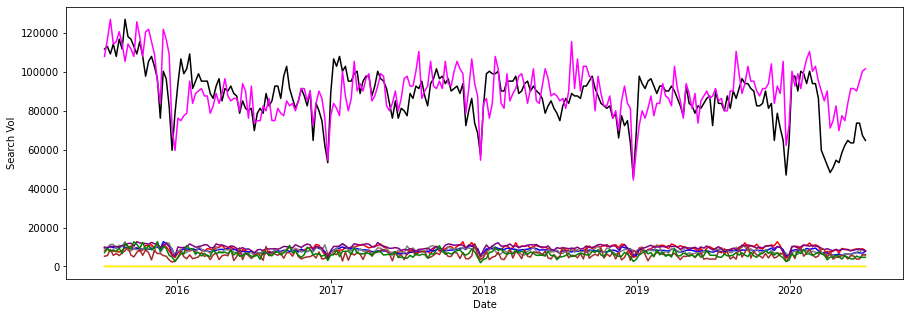

In [51]:
# Volume of searchs
sub_colors = {'presentation': 'red', 
              'a_4': 'orange', 
              'letter': 'blue', 
              'letterhead': 'grey',
              'resume': 'black',
              'presentation_4_3': 'yellow',
              'report': 'purple',
              'daily_report': 'brown',
              'memo': 'green',
              'invoice': 'magenta'}

plt.figure(figsize=(15,5))

for sub, colr in zip(sub_dic, sub_colors.values()):
    
    # Create a graph with the volume of searches
    ax = sns.lineplot(data=sub_dic[sub], 
                  x='Date', 
                  y='Search Vol',
                  color=colr)
    
# [Bonus] --> Adding legen with sub category name

Resume and Invoice sub-categories have much more search vol than the rest. For the sake of the analysis, could be interesting to add those sub-categories with less than 10.000 monthly visits.

In [54]:
# Same plot with subcategories with less than 10.000 monthly searches on average
sub_dic['agg'] = pd.DataFrame(columns = ['Date', 'Search Vol'])

for sub, colr in zip(sub_dic, sub_colors.values()):
    if (sub_dic[sub]['Search Vol'].mean() * 52) / 12 < 10000:
        sub_dic['agg'] = sub_dic['agg'].merge(sub_dic[sub], how="inner", on="Date")
    else:
        continue

sub_dic['agg']      

,Search Vol_x,Trend_x,isPartial_x,Min_x,Max_x,Average_x,Random_x,Searchs_x,Number of templates_x,Search Vol_y,Date,Trend_y,isPartial_y,Min_y,Max_y,Average_y,Random_y,Searchs_y,Number of templates_y,Search Vol


In [68]:
sub_dic['agg'] = sub_dic['agg'].merge(sub_dic['a_4'], how='left', on='Date', agg=('sum'))
sub_dic['agg']

TypeError: merge() got an unexpected keyword argument 'agg'

In [ ]:
# Combine all searches and find the trend. 
# We will be able to compare each sub_category with the overall trend
# Statistical analysis

## Bonus

1. Try to get the data with requests. Now it is hardcoded
2. Segment the subcategories by categories


In [ ]:
pd.DataFrame(columns=["Subcategory", "Categoty"])

In [ ]:
headers = {'authority': 'www.canva.com',
'method': 'GET',
'path': '/create-a-design',
'scheme': 'https',
'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
'accept-encoding': 'gzip, deflate, br',
'accept-language': 'en-US,en;q=0.9',
'cache-control': 'max-age=0',
'cookie': '__cfduid=dac51796841329b70661ebd07a4b3a8901591811643; CDI=888a9880-c327-4479-8e8b-9ba1da774a1a; CL=es-ES; ajs_group_id=null; ajs_anonymous_id=%22c1a4a653-107a-4341-b28e-dcdaf8b30169%22; _gcl_au=1.1.1259495208.1591811645; _ga=GA1.2.1022411617.1591811645; ab.storage.deviceId.320f7332-8571-45d7-b342-c54192dae547=%7B%22g%22%3A%223abc1a29-8121-d7ca-340a-f31fe27706a3%22%2C%22c%22%3A1591811645287%2C%22l%22%3A1591811645287%7D; _fbp=fb.1.1591811645414.41094145; CB=BADs5VlD2Bg; CS=1; ajs_user_id=%22UADs5dLCEjE%22; ab.storage.userId.320f7332-8571-45d7-b342-c54192dae547=%7B%22g%22%3A%22UADs5dLCEjE%22%2C%22c%22%3A1591811662791%2C%22l%22%3A1591811662791%7D; __stripe_mid=c81db500-bdf2-487a-a5ad-75ae9d22e99b; campaignTracker=CareersPage; _gid=GA1.2.1025166503.1593962736; CAZ=boxflnJsf51aH3f71XiopuK3CrO8cuyuw5GrquQTD0tB_GJG-s5RmTzX-G-dXfiWHRCZV2y7VciCP03NELbLJ5tNINCVqYopTdPp0n1kjTsxTykxlMMcONC6yL8Y-FDGr_yr6PwliRtGM8McXtxwoy1TY6qBhoKyCphBLIBg2ZpjJl5yTfHNdwnStMjDlJ3luXbDPF02J0GO2pQyiKvgMEIGohhRP54XtaKNrSHHpJtTRM9sTt1hjHgd-IUrOPEYDT0pS96LxcX1wRC_LrECNorvyQy6aQsWTstopMKSvJ6ZnbLh5Yu_5gWDcAUa2n1TkZI1zqHu_F_hQhTmOAH-60UskCnfkFHNa2UPQTkgbET9KsrE2cYhKWV3xrlh11zJSXjSK5KeRyurWLo6gkgcbxyOJhSs-eep2K7J4WC1MXUqUW2czm-NS4PZ8FTK-iEpBPpLp9vyMuSIFBR1q2pNKXYwZZRLhsmXAqYCvBsxUq-YdsJnftP06QLiyTJv_myWKX4n35ye1qsiuvQ9slYH6CrBfptmNSUFjK3ShZzrjCRiM2D4S9IfuEHizzp-C5cw8peDgnmIozjPZ4iaY-Nj0hDqvm1NNjb7KXarqVcH3B0xWoVKTP8ViM5hHDzvkHYx32EEr6vzsNQCowgbU09xZRHBkexnW-TRF2yvzAGrok4_SIrDZNXJgpFmC1kIj4bpzjtWgP12DVlh5Ozg-tXEtgTloa2SL0mSHchEG3N0FKcrc-3w; CID=_FTzF4vDbEzgzTdotlrRYpAVj_CG6qR2E5VkUbDA7N18UAf-k8DFGqh9ph_dViSM4aeyHv7RoKZ_MV12GlLN6znSv0OJoIst4JvST3qqAnKSVf72; CUI=RAVzK9FjV4qqVyq91U-AAcoMQOJY2LUfEowvOApAtSrMP9gIZpgZhHuTSb6HcZB_5HKR3w; _uetsid=76b9bd64-a296-63f2-c087-1570adb8bf21; _uetvid=233327d4-113a-e5a7-fd6f-b7cabb771c47; ab.storage.sessionId.320f7332-8571-45d7-b342-c54192dae547=%7B%22g%22%3A%22939a268b-0650-81f9-ceb0-7ab6c1e10c12%22%2C%22e%22%3A1594023258512%2C%22c%22%3A1594020164402%2C%22l%22%3A1594021458512%7D',
'sec-fetch-dest': 'document',
'sec-fetch-mode': 'navigate',
'sec-fetch-site': 'none',
'sec-fetch-user': '?1',
'upgrade-insecure-requests': '1',
'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36',
'token': '...'}


In [ ]:
soup.select('div', {'id':'genre-video'})

# soup2 = bs(subset, 'html.parser')

# soup2.find_all('p', {'class':'MpjE4w bSncsg n9zSJA ZTpOuQ u9XXAg HnhAQA l1bE7Q mNfh2Q'})

#for cat in subCat_list:
#    sub_cat.append(cat.text)

#        for card in soup.select("div.result-card__contents"):
 #           title = card.findChild("h3", recursive=False)
  #          company = card.findChild("h4", recursive=False)
   #         location = card.findChild("span", attrs={"class": "job-result-card__location"}, recursive=True)
    #        titles.append(title.string)
     #       companies.append(company.string)
      #      locations.append(location.string)


In [ ]:
#video = soup.find_all('div', {'class': 'K1bdNw ElK36A eGNjaw RTlscw'})

#[category.find('p', {'class': 'MpjE4w bSncsg n9zSJA ZTpOuQ u9XXAg HnhAQA l1bE7Q mNfh2Q'}).text for category in video]
    
#video_list = []
#for vid_cat in video:
#    video_list.append(vid_cat.text)
    
#video_list 